In [2]:
import numpy as np
import torch
from lib.models import iVAE
from lib.iFlow import iFlow
from lib.metrics import mean_corr_coef as mcc
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

from lib.data import DataLoaderGPU

In [23]:
def correlation_coefficients(x, y, method='pearson'):
    """
    A numpy implementation of the mean correlation coefficient metric.

    :param x: numpy.ndarray
    :param y: numpy.ndarray
    :param method: str, optional
            The method used to compute the correlation coefficients.
                The options are 'pearson' and 'spearman'
                'pearson':
                    use Pearson's correlation coefficient
                'spearman':
                    use Spearman's nonparametric rank correlation coefficient
    :return: float
    """
    d = x.shape[1]
    if method == 'pearson':
        cc = np.corrcoef(x, y, rowvar=False)[:d, d:]
    elif method == 'spearman':
        cc = spearmanr(x, y)[0][:d, d:]
    else:
        raise ValueError('not a valid method: {}'.format(method))
    cc_matrix = np.abs(cc)

    corr_coefs = cc_matrix[linear_sum_assignment(-1 * cc_matrix)] #.mean()
    return corr_coefs, cc_matrix

# Run model and create dataset (only once)

### Fill in script arguments

In [24]:
# Specify dataset string (same as first argument in python main.py command)
seed = 49
data_args = "1000_40_5_5_3_" + str(seed) + "_gauss_xtanh_u_f"
batch_size = 64
epochs = 20
i_what = 'iFlow' # 'iVAE' or 'iFLow'


#### Run model

In [22]:
# !python main.py --data-args=$data_args --epochs=$epochs --batch-size=$batch_size --i-what=$i_what --cuda --flow_type=RQNSF_AG --nat_param_act=Softplus --preload-gpu --lr_drop_factor=0.25

### Load model checkpoint

In [16]:
device = torch.device('cuda')


DATA_PATH = "data/1/" + "tcl_" + data_args[:-2] + ".npz"
print("DATA_PATH =", DATA_PATH)
# DATA_PATH = "data/1/tcl_100_40_5_5_3_1_gauss_xtanh_u.npz"

# Arguments (metadata, from argparse in main.py) have to correspond to selected dataset and model properties
metadata = {'file': DATA_PATH, 'path':DATA_PATH, 'batch_size': batch_size, 
            'epochs': epochs, 'device': device, 'seed': 1, 'i_what': i_what,
            
            'max_iter': None, 'hidden_dim': 50, 'depth': 3, 
            'lr': 1e-3, 'cuda': True, 'preload': True, 
            'anneal': False, 'log_freq': 25,  
            'flow_type': 'RQNSF_AG', 'num_bins': 8, 
            'nat_param_act': 'Softplus', 'gpu_id': '0', 
            'flow_length': 10, 'lr_drop_factor': 0.25, 
            'lr_patience': 10}

# Get arguments for dataset properties
train_loader = DataLoaderGPU(DATA_PATH, shuffle=True, batch_size=batch_size)
data_dim, latent_dim, aux_dim = train_loader.get_dims()
metadata.update(train_loader.get_metadata())

# Create model
model = None
if i_what == "iFlow":
    model = iFlow(args=metadata).to(device)
elif i_what == "iVAE":
    splitted_args = data_args.split("_")
    model = iVAE(int(splitted_args[2]), # latent_dim
                 int(splitted_args[3]), # data_dim
                 int(splitted_args[1]), # aux_dim
                 n_layers=metadata['depth'],
                 activation='lrelu',
                 device=device,
                 hidden_dim=metadata['hidden_dim'],
                 anneal=metadata['anneal']) # False



DATA_PATH = data/1/tcl_1000_40_5_5_3_49_gauss_xtanh_u.npz
data loaded on cuda


### Manually enter model checkpoint path

In [19]:
# CKPT_PATH = "experiments/2021-01-20_114830/ckpt/1/1_ckpt_20.pth"
CKPT_PATH = "experiments/2021-01-20_122315/ckpt/1/1_ckpt_10000.pth"
model.load_state_dict(torch.load(CKPT_PATH), strict=False)
model.eval()
pass # Remove cell ouput

# Uncomment if using different evaluation set
# DATA_PATH = "data/1/tcl_1_40_5_5_3_1_gauss_xtanh_u.npz"
# data_args = "1_40_5_5_3_1" + "_gauss_xtanh_u_f"

### Evaluate model performance

In [20]:
if model.__class__.__name__ == 'iFlow':
    import operator
    from functools import reduce
    total_num_examples = reduce(operator.mul, map(int, data_args.split('_')[:2]))
    model.set_mask(total_num_examples)

A = np.load(DATA_PATH)
x = A['x']
x = torch.from_numpy(x).to(device)
print("x.shape ==", x.shape)

s = A['s']
print("s.shape ==", s.shape)

u = A['u'] 
u = torch.from_numpy(u).to(device)
print("u.shape ==", u.shape)

if model.__class__.__name__ == 'iVAE':
    _, z_est = model.elbo(x, u)
elif model.__class__.__name__ == 'iFlow':
    z_est, nat_params = model.inference(x, u)

z_est = z_est.cpu().detach().numpy()
print("z_est.shape ==", z_est.shape)

perf = mcc(s, z_est)
print("EVAL PERFORMANCE: {}".format(perf))

corr_coefs, cc_matrix = correlation_coefficients(s, z_est)
print("CORRELATION MATRIX: \n{}".format(cc_matrix))
print("CORRELATION COEFFICIENTS: {}".format(corr_coefs))
print("DONE.")

x.shape == torch.Size([40, 5])
s.shape == (40, 5)
u.shape == torch.Size([40, 40])
z_est.shape == (40, 5)
EVAL PERFORMANCE: 0.5861285354300552
CORRELATION MATRIX: 
[[0.25551471 0.00920061 0.425184   0.60785478 0.65735233]
 [0.219595   0.52074766 0.54569559 0.34237384 0.15666986]
 [0.59014866 0.72264151 0.31602836 0.29142981 0.19781026]
 [0.31161444 0.0243769  0.09942104 0.47679517 0.17558297]
 [0.52815808 0.33520887 0.62313973 0.16322285 0.59671195]]
CORRELATION COEFFICIENTS: [0.65735233 0.54569559 0.72264151 0.47679517 0.52815808]
DONE.


### Visualizations (in progress)

In [12]:
# Get correlation coefficients
corr_coefs, _ = correlation_coefficients(s, z_est)

n, n_segments = u.shape
mean_source = np.zeros((5, n_segments))
mean_est = np.zeros((5, n_segments))

for i in range(n_segments):
    for dim in range(5):
        mean_source[dim][i] = np.mean(s[i*1000:(i+1)*1000, [dim]])
        mean_est[dim][i] = np.mean(z_est[i*1000:(i+1)*1000, [dim]])
        
#         axes[dim].plot(mean_source[i])
#         axes[dim].plot(mean_est[i])

# Standardize both signals (mean=0, std=1)
mean_source = (mean_source - np.mean(mean_source, axis=0)) / np.std(mean_source, axis=0)
mean_est = (mean_est - np.mean(mean_est, axis=0)) / np.std(mean_est, axis=0)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.tight_layout()

for i in range(5):
    axes[i].plot(mean_source[i], linestyle='-.')
    axes[i].plot(mean_est[i], linestyle='-.')
    axes[i].set_title("corr: " + str(round(corr_coefs[i], 4)))
plt.show()



NameError: name 's' is not defined

FO

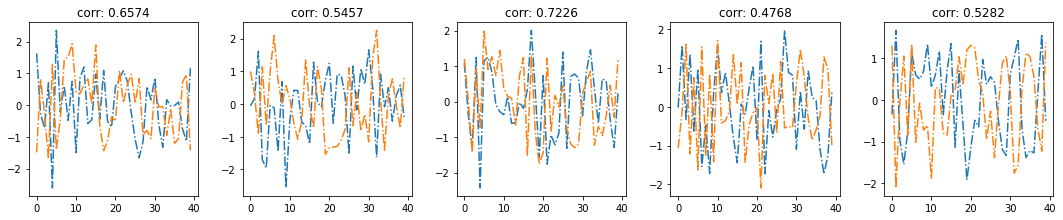

In [21]:
# Get correlation coefficients
corr_coefs, _ = correlation_coefficients(s, z_est)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.tight_layout()

for i in range(5):
    source = s[:, [i]]
    est = z_est[:, [i]]

    # Standardize both signals (mean=0, std=1)
    source = (source - np.mean(source)) / np.std(source)
    est = (est - np.mean(est)) / np.std(est)
    
    axes[i].plot(source, linestyle='-.')
    axes[i].plot(est, linestyle='-.')
    axes[i].set_title("corr: " + str(round(corr_coefs[i], 4)))
plt.show()

#######################
# Some notable differences:
# A sign flip, original authors might have removed any permutations (sign-flips) already such that negative 
# correlations are avoided in the plotted Figures.

# The signals in our Figures are less aligned.

0.19268861
-0.19579336
[1.4287467]


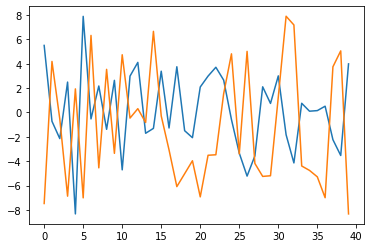

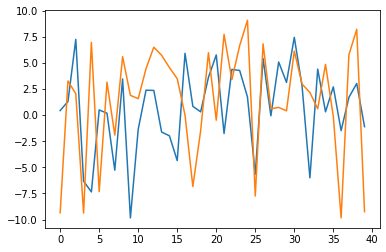

In [37]:
source_dim1 = s[:,[0]]
source_dim2 = s[:,[1]]
est_dim1 = z_est[:, [0]]
est_dim2 = z_est[:, [1]]


from sklearn.preprocessing import StandardScaler

# Preprocessing
# sc_dim1 = StandardScaler()
# source_dim1 = sc_dim1.fit_transform(source_dim1) #- source_dim1.mean()
# est_dim1 = sc_dim1.transform(est_dim1) #- est_dim1.mean()

# sc_dim2 = StandardScaler()
# source_dim2 = sc_dim2.fit_transform(source_dim2) #- source_dim2.mean()
# est_dim2 = sc_dim2.transform(est_dim2) #- est_dim2.mean()



# plt.plot(source_dim1 / source_dim1.max())
# plt.plot(est_dim1 / source_dim1.max())
# plt.show()

# plt.plot(source_dim2 / source_dim2.max())
# plt.plot(est_dim2 / source_dim2.max())
# plt.show()


print(source_dim1.mean())
print(est_dim1.mean())
print(abs(max(est_dim2, key=abs)))
    
plt.plot(source_dim1)
plt.plot(est_dim1 / abs(max(est_dim1, key=abs)) * abs(max(source_dim1, key=abs))) 
plt.show()

plt.plot(source_dim2)
plt.plot(est_dim2 / abs(max(est_dim2, key=abs)) * abs(max(source_dim2, key=abs)))
plt.show()



# plt.plot(source_dim1[200:250], color='b')
# plt.plot(est_dim1[200:250], color='y')
# plt.title('First dimension')
# plt.show()

# plt.plot(source_dim2[200:250], color='b')
# plt.plot(est_dim2[200:250], color='y')
# plt.title('Second dimension')
# plt.show()

In [4]:
# Initialize model with correct arguments
# latent_dim = 2
# data_dim = 2
# aux_dim = 5
# n_layers = 3
# activation = 'lrelu'
# device = torch.device('cuda')
# hidden_dim = 50
# anneal = False


# model = iVAE(latent_dim, \
#                  data_dim, \
#                  aux_dim, \
#                  n_layers, \
#                  activation, \
#                  device, \
#                  hidden_dim, \
#                  anneal) # False


# model.load_state_dict(torch.load(PATH))
# model.eval()


NameError: name 'iVAE' is not defined